# Bayesian Principal Component Analysis

<br><br>
<img src='BPCA.jpg' width=500>

In [1]:
import inferpy as inf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Definition of a generic prababilistic model
<br><br>
<img src='PCA.jpg' width=200>

In [2]:
@inf.probmodel
def pca(K,D,sigma2=0.1): # Assumption: K < D
    
    # W is an expansion of a low-dim space
    W = inf.Normal(loc=np.zeros([D]), scale=1, name="W", sample_shape=K) # shape = [K,D]
    
    with inf.datamodel(): # define local parameters 
        # z in a lower dim space
        Z = inf.Normal(np.zeros(K),1, name="Z")                # shape = [N,K]
        #             (N,K) (K,D)
        X = inf.Normal(Z @ W , sigma2, name="x")                     # shape = [N,D]

In [3]:
N = 100
model = pca(1,2)
X_gen = model.prior(['x'], data={'W': np.array([[0,1]])}, size_datamodel = N).sample()


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


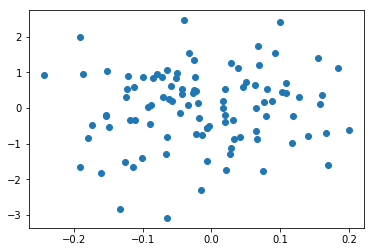

In [4]:
_=plt.plot(*X_gen.T,'o')

## Define the Q-model

In [5]:
@inf.probmodel
def qmodel(K,D):
    
    qW_loc = inf.Parameter(tf.ones([K,D]), name = 'qW_loc')
    qW_scale = tf.math.softplus(inf.Parameter(tf.ones([K,D]), name = 'qW_scale'))
    
    qW = inf.Normal(qW_loc, qW_scale, name = 'W')
    
    with inf.datamodel():
        
        qZ_loc = inf.Parameter(tf.ones([K]), name='qZ_loc')
        qZ_scale = tf.math.softplus(inf.Parameter(tf.ones([K]), name = 'qZ_scale'))
        
        qZ = inf.Normal(qZ_loc,qZ_scale,name = 'Z')
        

In [6]:
from sklearn.model_selection import train_test_split
X_tr, X_te = train_test_split(X_gen, test_size = 0.2, random_state = 42)
X_tr.shape, X_te.shape

((80, 2), (20, 2))

In [7]:
qm = qmodel(1,2)
VI = inf.inference.VI(qm, epochs=50000, optimizer=tf.compat.v1.train.AdamOptimizer(0.01))

In [8]:
model.fit({'x':X_tr}, VI)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

 0 epochs	 75334.0859375....................
 200 epochs	 26935.630859375....................
 400 epochs	 7842.7900390625....................
 600 epochs	 4301.8720703125....................
 800 epochs	 4761.67333984375....................
 1000 epochs	 1944.9354248046875....................
 1200 epochs	 1606.8858642578125....................
 1400 epochs	 1185.621826171875....................
 1600 epochs	 954.1097412109375....................
 1800 epochs	 294.3020324707031....................
 2000 epochs	 455.9883728027344....................
 2200 epochs	 440.61859130859375....................
 2400 epochs	 194.52195739746094....................
 2600 epochs	 120.91301727294922....................
 2800 epochs	 210.1150665283203....................
 3000 epochs	 182.07418823242188....................
 3200 epochs	 207.8995819091797....................
 3400 epochs	 231.74139404296875.

In [12]:
ppar = model.posterior(['W','Z'], data = {'x':X_tr}).parameters()
Wp = ppar['W']['loc']#.keys()
Zp = ppar['Z']['loc']

In [13]:
Wp

array([[-0.00111919,  0.9972311 ]], dtype=float32)

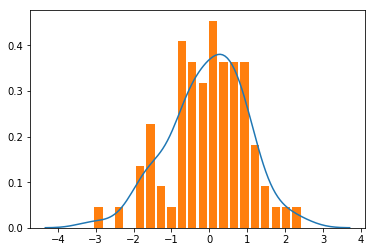

In [16]:
import seaborn as sns
sns.kdeplot(Zp.ravel())
_=plt.hist(Zp,bins=20,rwidth=0.8, density=True)

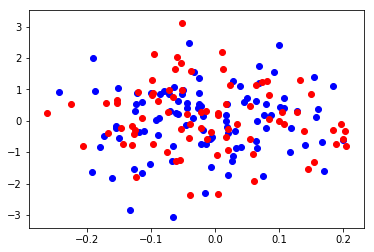

In [17]:
XX = model.posterior_predictive().sample()
#XX = XX.mean(0)
plt.scatter(*X_gen.T,c='b',label='Data')
_=plt.scatter(*XX.T,c='r',label='Post Predictive')